In [1]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, warnings, pickle, plotly, plotly.express as px, altair as alt
from utils import data_preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [2]:
df = pd.read_csv('data/AB_NYC_2019.csv')

In [3]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [5]:
df.isna().sum().apply(lambda x: f'{100 * (x / df.shape[0]):.2f}%')

id                                 0.00%
name                               0.03%
host_id                            0.00%
host_name                          0.04%
neighbourhood_group                0.00%
neighbourhood                      0.00%
latitude                           0.00%
longitude                          0.00%
room_type                          0.00%
price                              0.00%
minimum_nights                     0.00%
number_of_reviews                  0.00%
last_review                       20.56%
reviews_per_month                 20.56%
calculated_host_listings_count     0.00%
availability_365                   0.00%
dtype: object

## Categorical Features

`neighbourhood_group`: NYC district on the highest municipal level

<AxesSubplot: xlabel='neighbourhood_group', ylabel='count'>

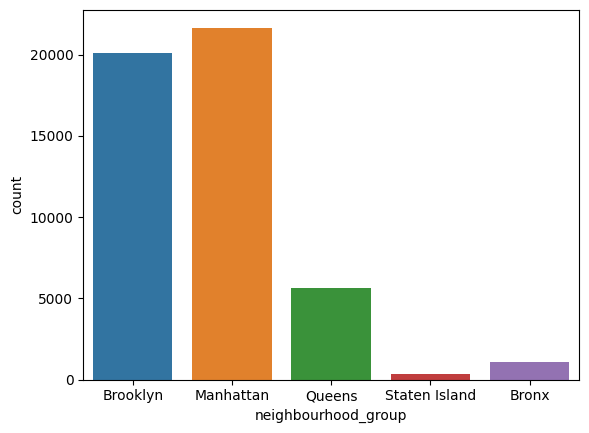

In [6]:
sns.countplot(x='neighbourhood_group', data=df)

Outstanding majority of the listings are located in either Brooklyn or Manhattan. We can group the remaining 3 neighborhoods in the "Other" category and then one-hot encode the features. This way we dispose of the low-frequency categories which will create rather sparse features, poorly contributing to the training and making it less efficient

In [7]:
df['neighbourhood_group_3'] = df['neighbourhood_group'].apply(lambda x: 'Brooklyn' if x == 'Brooklyn' else 'Manhattan' if x == 'Manhattan' else 'Other')
df = pd.concat([df, pd.get_dummies(df['neighbourhood_group_3'])], axis=1)

`neighbourhood`: lower-level NYC district

<AxesSubplot: xlabel='neighbourhood', ylabel='count'>

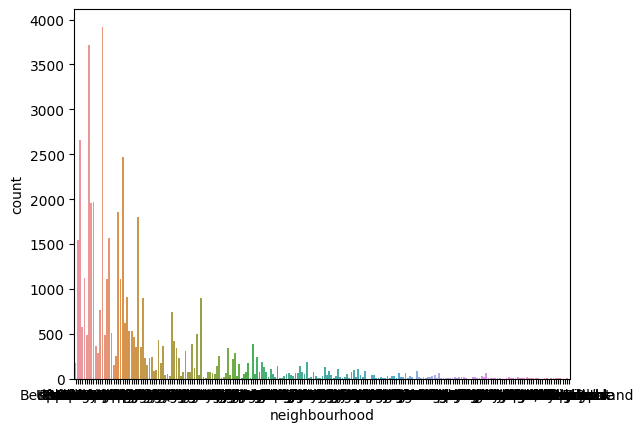

In [8]:
sns.countplot(x='neighbourhood', data=df)

Too many categories, and besides we already have a variable identifying the neighborhood. Therefore, this variable will not be included to the models

`room_type`: Airbnb-defined room type

<AxesSubplot: xlabel='room_type', ylabel='count'>

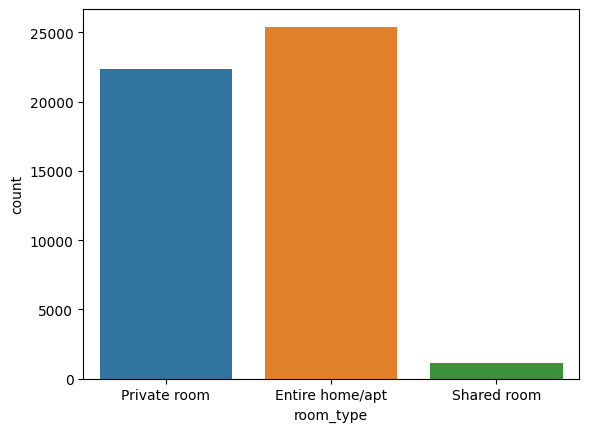

In [9]:
sns.countplot(x='room_type', data=df)

Outstanding majority of the accommodations is either a private room, or an entire home/apartment. We will drop all the shared room apartments, as their share in the data is very small, and make room type a dummy variable

In [10]:
df_no_shared = df.query('room_type != "Shared room"')
df_no_shared['room_type_d'] = np.where(df_no_shared['room_type'] == 'Private room', 1, 0)

In [11]:
cat_features = ['room_type_d', 'Brooklyn', 'Manhattan', 'Other']
df_no_shared.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_3,Brooklyn,Manhattan,Other,room_type_d
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,Brooklyn,1,0,0,1
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,Manhattan,0,1,0,0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,Manhattan,0,1,0,1
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,Brooklyn,1,0,0,0
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,Manhattan,0,1,0,0


## Numeric Features

`latitude` & `longitude`: geographical coordinates of the accommodation

We can use coordinates to calculate a distance from the accommodation to some popular landmark. In our case for each accommodation we will calculate the distance to the Statue of Liberty

In [12]:
df_no_shared['dist_to_stl'] = data_preprocessing.calculate_distance(df_no_shared['latitude'].to_numpy(), df_no_shared['longitude'].to_numpy())

<AxesSubplot: >

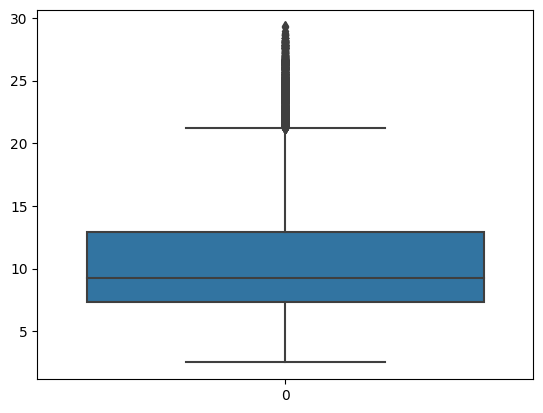

In [13]:
sns.boxplot(df_no_shared['dist_to_stl'])

`minimum_nights`: a minimum number of nights required to make a booking

<AxesSubplot: >

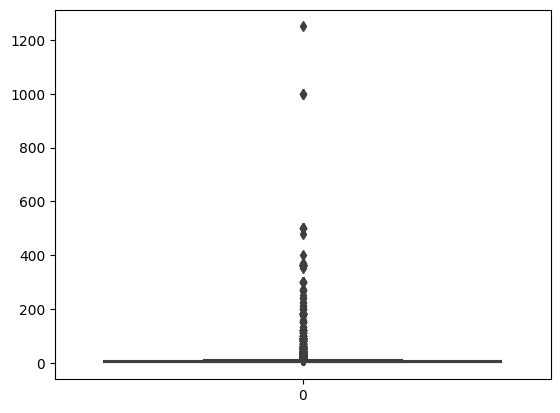

In [14]:
sns.boxplot(df_no_shared['minimum_nights'])

The variable is highly right-skewed. Let us see how many of the variable's values are outliers

In [15]:
outliers = data_preprocessing.get_outliers(df_no_shared['minimum_nights'])

Share of outliers: 13.53%


There are too many outliers to simply drop. Let us see the distribution of the outliers themselves

<AxesSubplot: >

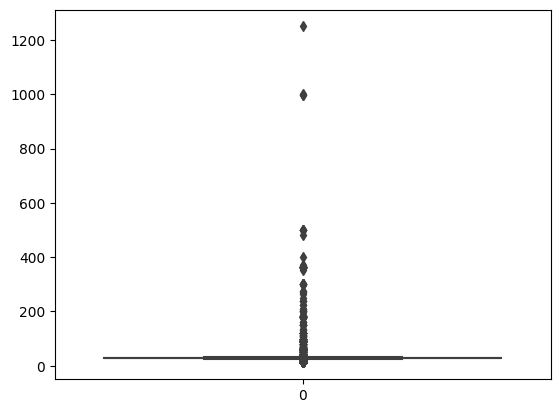

In [16]:
sns.boxplot(outliers)

The outliers themselves are skewed as well, but what are the exact quartile values?

In [17]:
outliers_s = pd.Series(outliers).describe()
outliers_s

count    6457.000000
mean       34.666873
std        45.865997
min        12.000000
25%        28.000000
50%        30.000000
75%        30.000000
max      1250.000000
dtype: float64

We can leave all the listings which are to be rented minimally for no longer than 30 days. The rest will be dropped, since Airbnb is a platform for short-term rentals, and accommodations rented out for longer do not fit the idea of the service

In [18]:
df_min_nights_no_out = df_no_shared.query('minimum_nights <= 30')
f"Share of outliers: {100 * (len(outliers_s[outliers_s > 30]) / df_no_shared['minimum_nights'].shape[0]):.4f}%"

'Share of outliers: 0.0084%'

<AxesSubplot: >

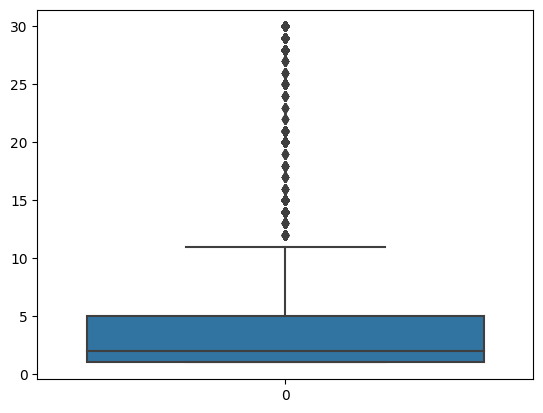

In [19]:
sns.boxplot(df_min_nights_no_out['minimum_nights'])

`reviews_per_month`: average number of reviews the listing is getting

<AxesSubplot: >

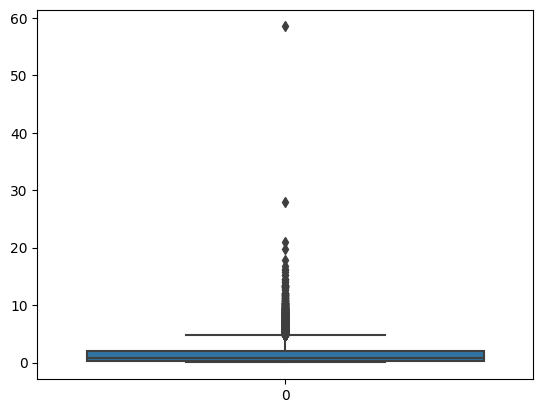

In [20]:
sns.boxplot(df_min_nights_no_out['reviews_per_month'])

The variable is skewed as well, but there is no reasoning advocating the outliers removal. In addition, this variable has quite a lot of missings, which we will try to infer from other variables, which are:
- Neighborhood dummies
- Room type
- Distance to the Statue of Liberty
- Price

In [21]:
# scale numeric features as KNN is a distance-based algo
st_scaler = StandardScaler()
df_imputing = df_min_nights_no_out[cat_features + ['price', 'dist_to_stl', 'reviews_per_month']]
df_imputing[['price', 'dist_to_stl']] = st_scaler.fit_transform(df_imputing[['price', 'dist_to_stl']])

# separate the data into "training" and "test" sets based on presence of NaN
df_imp_train = df_imputing[~df_imputing['reviews_per_month'].isna()]
y_imp_train = df_imputing['reviews_per_month'][~df_imputing['reviews_per_month'].isna()]
df_imp_test = df_imputing[df_imputing['reviews_per_month'].isna()]

# create the KNN model, fit, and predict the missings
knn_imp = KNeighborsRegressor(weights='distance')
knn_imp.fit(df_imp_train.drop('reviews_per_month', axis=1), y_imp_train)
reviews_month_pred = knn_imp.predict(df_imp_test.drop('reviews_per_month', axis=1))

# convert predictions into missings, assign them indices, replace NaNs by index
reviews_month_pred = pd.Series(reviews_month_pred, index=df_imputing['reviews_per_month'][df_imputing['reviews_per_month'].isna()].index)
df_min_nights_no_out['reviews_per_month'].fillna(reviews_month_pred, inplace=True)

`number_of_reviews`: total number of reviews per listing

Correlation coefficient: 0.52
P-value: 0.0


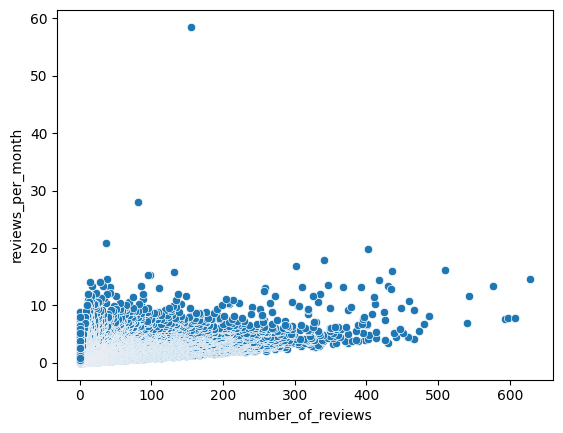

In [22]:
sns.scatterplot(x=df_min_nights_no_out['number_of_reviews'], y=df_min_nights_no_out['reviews_per_month'])
corr = stats.pearsonr(df_min_nights_no_out['number_of_reviews'], df_min_nights_no_out['reviews_per_month'])
print(f"Correlation coefficient: {round(corr[0], 2)}\nP-value: {corr[1]}")

These 2 variables are obviously correlated, so we need only one of them. Reviews per month seems a better option, since it compares apartments on a relative scale, and moreover the time period is unknown

`calculated_host_listings_count`: how many apartments is a host renting out

<AxesSubplot: >

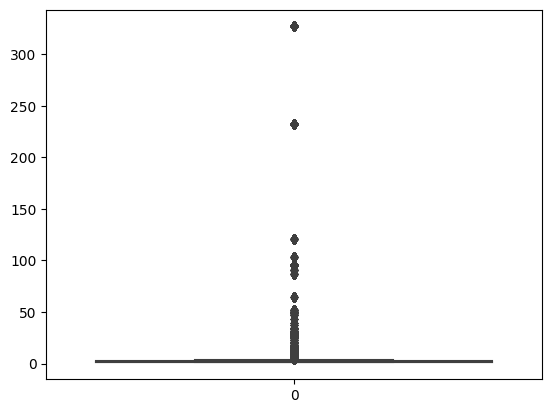

In [23]:
sns.boxplot(df_min_nights_no_out['calculated_host_listings_count'])

In [24]:
outliers = data_preprocessing.get_outliers(df_min_nights_no_out['calculated_host_listings_count'])

Share of outliers: 13.79%


In [25]:
pd.Series(outliers).describe()

count    6484.000000
mean       44.160703
std        80.735764
min         4.000000
25%         5.000000
50%         8.000000
75%        34.000000
max       327.000000
dtype: float64

We will keep the listings of those hosts who have no more than 8 distinct listings. While 8 is already a pretty high number, it is still possible to imagine there may be a host who owns, say, 2 4-bedroom houses and rents out every bedroom separately. Starting from the 3rd quartile the values become unrealistically high for them to belong to a single host

In [26]:
df_n_listings_no_out = df_min_nights_no_out.query('calculated_host_listings_count <= 8')
f"Share of outliers: {100 * (len(outliers_s[outliers_s > 8]) / df_min_nights_no_out['calculated_host_listings_count'].shape[0]):.4f}%"

'Share of outliers: 0.0170%'

`availability_365`: how many days per year the apartment is available for booking

<AxesSubplot: >

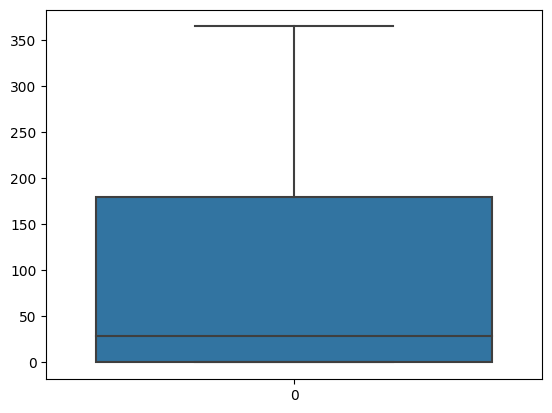

In [27]:
sns.boxplot(df_n_listings_no_out['availability_365'])

In [28]:
num_features = ['dist_to_stl', 'minimum_nights', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

## Target Variable

<AxesSubplot: >

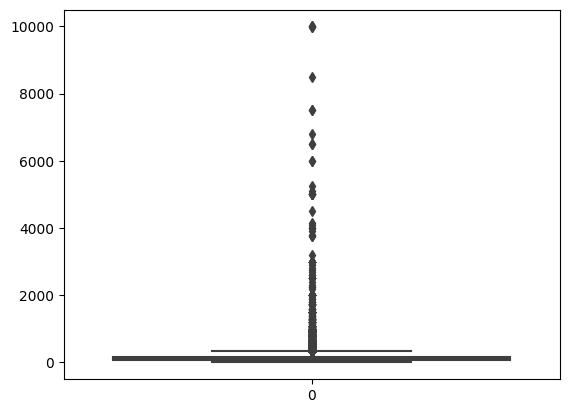

In [29]:
sns.boxplot(df_n_listings_no_out['price'])

Despite a large number of outliers, we cannot obviously drop them, since there is no reasoning to justify it. We can, however, log-transform the variable, but we need to make sure there are no zero-priced apartments, which we need to dispose of from the common sense

In [30]:
df_n_listings_no_out['price'].describe()

count    43820.000000
mean       149.198106
std        219.277449
min          0.000000
25%         70.000000
50%        105.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

Evidently there are some listings with the price 0, how many of them are there?

In [31]:
df_n_listings_no_out['price'][df_n_listings_no_out['price'] == 0].shape[0]

9

There are very few of them, we can safely drop these rows

<AxesSubplot: >

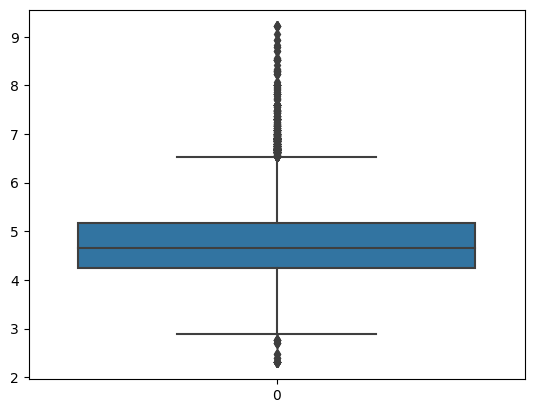

In [32]:
df_non_zero_price = df_n_listings_no_out.query('price > 0')
df_non_zero_price['price_log'] = np.log(df_n_listings_no_out['price'])
sns.boxplot(df_non_zero_price['price_log'])

Now the distribution is more symmetric. However, both for the predictions and error metrics (e.g. $R^{2}$) to make sense, we will need to take exponent

## Preparing Clustering Input

In [33]:
print('There are', df_non_zero_price['name'].isnull().sum(), 'apartments with missing names')
df_non_zero_price.dropna(subset=['name'], inplace=True)
print('There are', df_non_zero_price['name'].isnull().sum(), 'apartments with missing names')

There are 14 apartments with missing names
There are 0 apartments with missing names


In [34]:
X_cluster = data_preprocessing.preprocess_names(df_non_zero_price['name'])

In [37]:
with open('data/X_cluster.pkl', 'wb') as f:
    pickle.dump(X_cluster, f)

## Preparing Models Input

In [ ]:
# creating inputs and labels
X = df_non_zero_price[num_features + cat_features]
y = df_non_zero_price['price_log']

# scaling numeric features
X[num_features] = st_scaler.fit_transform(X[num_features])

# converting to np arrays for higher training performance
X, y = X.to_numpy(), y.to_numpy()

# generating train and test sets, writing them into pickle files
np.random.seed(111) # for reproducibility
train_test_array = train_test_split(X, y, test_size=0.25)
train_test_labels = ['X_train', 'X_test', 'y_train', 'y_test']
for i in range(len(train_test_array)):
    with open(f"data/{train_test_labels[i]}.pkl", 'wb') as f:
        pickle.dump(train_test_array[i], f)

## Presentation Charts

In [ ]:
Create_map = df_non_zero_price[['latitude','longitude','price_log']]
with open('mapbox_tkn.txt', 'r') as f:
    mapbox_key = f.read().strip()
fig = px.scatter_mapbox(Create_map, lat="latitude", lon="longitude",color='price_log', opacity=0.2)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

In [35]:
plotly.offline.plot(fig, filename='figures/map.html')

'figures/map.html'

In [ ]:
alt.Chart(df_non_zero_price.query('room_type != "Shared"'), padding={"left": 10, "top": 10, "right": 10, "bottom": 10}).mark_bar().encode(
    alt.X('neighbourhood_group_3:O', title='', axis=None),
    alt.Y('price:Q', title='Mean Price, USD', aggregate='mean', axis=alt.Axis(grid=True)),
    alt.Facet('room_type:N', title='Apartment Mean Price by Room Type'),
    alt.Color('neighbourhood_group_3:N', title='')
).properties(
    width = 350, height = 400
).configure_axis(
    labelFontSize=14, titleFontSize=16
).configure_title(
    fontSize=21
).configure_header(
    labelFontSize=14, labelOrient='bottom', labelPadding=3, titleFontSize=18
).configure_facet(
    spacing=5
)

In [ ]:
alt.Chart(df_non_zero_price, padding={"left": 10, "top": 10, "right": 10, "bottom": 10}).mark_bar().encode(
    alt.X('neighbourhood_group:N', title='', axis=alt.Axis(labelAngle=-360), sort='-y'),
    alt.Y('neighbourhood_group:N', title='', aggregate='count'),
).properties(
    width = 350, height = 400, title='Distribution of listings by Neighborhood Groups'
).configure_axis(
    labelFontSize=14, titleFontSize=16
).configure_title(
    fontSize=21
)

In [ ]:
alt.Chart(df_non_zero_price, padding={"left": 10, "top": 10, "right": 10, "bottom": 10}).mark_bar().encode(
    alt.X('neighbourhood:N', title='', axis=alt.Axis(labelAngle=-360), sort='-y'),
    alt.Y('neighbourhood:N', title='', aggregate='count'),
).properties(
    width = 350, height = 400, title='Distribution of listings by Neighborhoods'
).configure_axis(
    labelFontSize=14, titleFontSize=16
).configure_title(
    fontSize=21
)

In [ ]:

scatter = alt.Chart(df_non_zero_price).mark_point().encode(
    x=alt.X('dist_to_stl', title='Distance to the Statue of Liberty, km'),
    y=alt.Y('price_log', title='Price, USD (log scale)')
)

corr = stats.pearsonr(df_non_zero_price['dist_to_stl'], df_non_zero_price['price_log'])
text = alt.Chart({'values':[{}]}).mark_text(
    align="left", baseline="top"
).encode(
    x=alt.value(5),
    y=alt.value(5),
    text=alt.value(f"R: {corr[0]:.2f} P-value: {corr[1]}"),
)

(scatter + text).properties(
    width = 350, height = 400
).configure_axis(
    labelFontSize=14, titleFontSize=16
).configure_title(
    fontSize=21
)

In [40]:
df.groupby('room_type').agg({'room_type': 'count'}).rename(columns={'room_type': 'Count'}).reset_index().rename(columns={'room_type': 'Room Type'}).to_excel('figures/room_type.xlsx', index=False)

In [ ]:
scatter = alt.Chart(df_non_zero_price).mark_point().encode(
    x=alt.X('number_of_reviews', title='Number of Reviews'),
    y=alt.Y('reviews_per_month', title='Average Reviews per Month')
)

corr = stats.pearsonr(df_non_zero_price['number_of_reviews'], df_non_zero_price['reviews_per_month'])
text = alt.Chart({'values':[{}]}).mark_text(
    align="left", baseline="top"
).encode(
    x=alt.value(5),
    y=alt.value(5),
    text=alt.value(f"R: {corr[0]:.2f} P-value: {corr[1]}"),
)

(scatter + text).properties(
    width = 350, height = 400
).configure_axis(
    labelFontSize=14, titleFontSize=16
).configure_title(
    fontSize=21
)

In [ ]:
alt.Chart(df_non_zero_price, padding={"left": 10, "top": 10, "right": 10, "bottom": 10}).mark_boxplot(size=100).encode(
    x=alt.X('a:N', title='Log of Price', axis=alt.Axis(ticks=False, domain=False, labels=False)),
    y=alt.Y('price_log', title='')
).properties(
    width = 350, height = 400, title='Price (log) Distribution'
).configure_axis(
    labelFontSize=14, titleFontSize=16
).configure_title(
    fontSize=21
)

In [ ]:
alt.Chart(df_non_zero_price, padding={"left": 10, "top": 10, "right": 10, "bottom": 10}).mark_boxplot(size=100).encode(
    x=alt.X('a:N', title='Price', axis=alt.Axis(ticks=False, domain=False, labels=False)),
    y=alt.Y('price', title='')
).properties(
    width = 350, height = 400, title='Price Distribution'
).configure_axis(
    labelFontSize=14, titleFontSize=16
).configure_title(
    fontSize=21
)